# ASR post-processing corrector pred vs gold

## TRAIN

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Load training examples

## For each BUILD subsplit match gold with pred of split audio

## Save training set

In [2]:
error_correction_training_fn='foo.tsv'

## Create consolidated vocabulary

In [2]:
graphemes=[' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
           'r','s','t','u','v','w','x','y','à','á','â','ã','è','é','ê','ì','í','ò',
           'ó','ô','õ','ù','ú','ý','ă','đ','ĩ','ũ','ơ','ư','ạ','ả','ấ','ầ','ẩ','ẫ',
           'ậ','ắ','ằ','ẳ','ẵ','ặ','ẹ','ẻ','ẽ','ế','ề','ể','ễ','ệ',
           'ỉ','ị','ọ','ỏ','ố','ồ','ổ','ỗ','ộ','ớ','ờ','ở','ỡ','ợ',
           'ụ','ủ','ứ','ừ','ử','ữ','ự','ỳ','ỷ','ỹ']

## Build model

In [3]:
MAX_LENGTH=496

import random
import torch
from torchtext.data import Field, BucketIterator, Iterator, TabularDataset
from tqdm.auto import tqdm
import os
from initialize_weights import initialize_weights

In [4]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)


## Model

MIN_FREQ=1

SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

from seq_to_seq import *

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

from count_parameters import count_parameters

print(f'The model has {count_parameters(model):,} trainable parameters')


model_fn='save/new_afterburner/afterburner_302.pt'
model.apply(initialize_weights);

The model has 4,281,440 trainable parameters


In [5]:
if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))
    print('load pretrained')

load pretrained


## Augment training

In [8]:
with open('traindata_vietnamese.tsv', 'r', encoding='utf-8') as f:
    data=f.read()

In [10]:
d0=data.split('\n')

In [11]:
d1=[x.split('\t') for x in d0]

In [12]:
augment=[(y,y) for x,y in d1]

In [13]:
d2=d1+augment

In [16]:
import random

In [17]:
random.shuffle(d2)

In [18]:
tdata='\n'.join([f'{x}\t{y}' for x,y in d2])

In [19]:
tdata[0:100]

'xong rồi thì lút sớm ngày mai về\txong rồi thì lúc sớm ngày mai về\nthế á\tthế á\nừ giờ kiểm tra thật mà'

In [20]:
with open('traindata_vietnamese_augmented.tsv', 'w', encoding='utf-8') as f:
    f.write(tdata)

## Trainer

In [21]:
error_correction_training_fn='traindata_vietnamese_augmented.tsv'

In [22]:
## Data loader

train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)])


In [23]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [24]:
model.train();

In [ ]:
batch_size=32
train_iterator = Iterator(train_data, batch_size=batch_size)
print(f'{len(train_iterator)} batches / epoch')
%matplotlib notebook
import matplotlib.pyplot as plt
from progress_bar import progress_bar

<IPython.core.display.Javascript object>


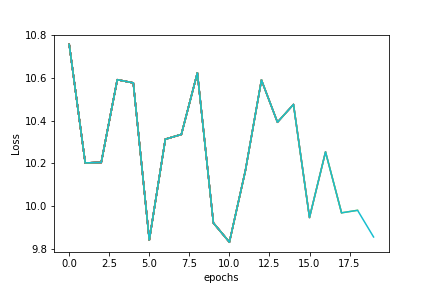

[0] 10.75640974054113
[1] 10.20229370240122
[2] 10.204403770854697
[3] 10.59151402534917
[4] 10.57656413805671
[5] 9.842002667021006
[6] 10.313128557405435
[7] 10.335407198406756
[8] 10.623273303965107
[9] 9.921330367447808
[10] 9.831642528064549
[11] 10.167027406394482
[12] 10.58979825838469
[13] 10.392512153601274
[14] 10.475842714775354
[15] 9.946925827069208
[16] 10.253708660136908
[17] 9.968667321139947
[18] 9.980472743860446
[19] 9.855658009182662


In [28]:
epoch_loss = 9999999999999999
j=0
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
losses = []
for j in range(20):
    epoch_loss = 0
    for i, batch in enumerate(train_iterator):
        src = batch.src.to(device)
        trg = batch.trg.to(device)
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f'[{j}] {epoch_loss}')
    progress_bar(fig, ax, losses)

In [29]:
!mkdir -p save/new_afterburner
model_fn='save/new_afterburner/afterburner_302.pt'
torch.save(model.state_dict(), model_fn)

## INFER

## Translate pred to gold and check WER

In [ ]:
['a lô ừ nấu cơm chưa',
 'ăn gì ngon há',
 'buồn ngủ lại đi ngủ',
 'ừ ừ',
 'tại ốm quá chứ mẹ đi chợ à'

In [50]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import os, pickle, random, torch
from tqdm.auto import tqdm
from count_parameters import count_parameters
from initialize_weights import initialize_weights
from calculate_cer import calculate_cer
from calculate_wer import calculate_wer
from prediction_to_string import prediction_to_string
from torchtext.data import Field, BucketIterator
from torchtext.data import Iterator
from torchtext.data import TabularDataset
import torch.nn as nn
from seq_to_seq import *

In [ ]:
error_correction_training_fn='foo.tsv'
model_fn='save/new_afterburner/afterburner_300.pt'

In [ ]:
graphemes=[' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
           'r','s','t','u','v','w','x','y','à','á','â','ã','è','é','ê','ì','í','ò',
           'ó','ô','õ','ù','ú','ý','ă','đ','ĩ','ũ','ơ','ư','ạ','ả','ấ','ầ','ẩ','ẫ',
           'ậ','ắ','ằ','ẳ','ẵ','ặ','ẹ','ẻ','ẽ','ế','ề','ể','ễ','ệ',
           'ỉ','ị','ọ','ỏ','ố','ồ','ổ','ỗ','ộ','ớ','ờ','ở','ỡ','ợ',
           'ụ','ủ','ứ','ừ','ử','ữ','ự','ỳ','ỷ','ỹ']

In [ ]:
MAX_LENGTH=496
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

In [ ]:
batch_size=32
train_iterator = Iterator(train_data, batch_size=batch_size)

In [ ]:
## Model

MIN_FREQ=1

SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

print(f'The model has {count_parameters(model):,} trainable parameters')

model.apply(initialize_weights);
if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))
    print('reloaded trained model')

In [ ]:
model.eval();
R=[]
for i, batch in enumerate(tqdm(train_iterator)):
    src = batch.src.to(device)
    trg = batch.trg.to(device)
    output, _ = model(src, trg[:,:-1])
    output_dim = output.shape[-1]
    output = output.contiguous().view(-1, output_dim)
    trg = trg[:,1:].contiguous().view(-1)   
    prediction=prediction_to_string(TRG, batch_size, output, False)
    gold=prediction_to_string(TRG, batch_size, trg, True)   
    for hyp,au in zip(prediction, gold):
        R.append((au,hyp,calculate_cer(hyp, au),calculate_wer(hyp, au)))

In [ ]:
R=[(au.strip(), hyp.strip(), cer, wer) for au, hyp, cer, wer in R if '<pad>' not in au]

In [ ]:
['a lô ừ nấu cơm chưa',
 'ăn gì ngon há',
 'buồn ngủ lại đi ngủ',
 'ừ ừ',
 'tại ốm quá chứ mẹ đi chợ à'

In [ ]:
R[0:5]

In [ ]:
import pandas as pd
results=pd.DataFrame(R, columns=['Gold', 'Pred', 'CER', 'WER'])
results['GOLD_n_words']=results['Gold'].apply(lambda x: len(x.split(' ')))
results['GOLD_n_chars']=results['Gold'].apply(lambda x: len(x))
results['CER_pct']=results.CER/results['GOLD_n_chars']
results['WER_pct']=results.CER/results['GOLD_n_words']
results=results[results.Gold != '<pad>']
results

In [ ]:
%matplotlib notebook
results.WER_pct.hist(bins=10)

In [ ]:
results.WER_pct.mean(), results.CER_pct.mean()